In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import time

# Data Pulling


In [2]:
artists = pd.read_csv('data/input/artists_reduced.csv')
designers = pd.read_csv('data/input/designers_reduced.csv')
games = pd.read_csv('data/input/games.csv')
mechanics = pd.read_csv('data/input/mechanics.csv')
publishers = pd.read_csv('data/input/publishers_reduced.csv')
ratings_dist = pd.read_csv('data/input/ratings_distribution.csv')
subcategories = pd.read_csv('data/input/subcategories.csv')
themes = pd.read_csv('data/input/themes.csv')
user_ratings = pd.read_csv('data/input/user_ratings.csv')

# Data Transformation

## Artists
- BGG ID
- Low-Exp artists indicates the game has an unlisted artist w/ < 3 games
- 1 column per artist name (1/0 indicates the artist)

**Transformation needed: sum all columns all to get the total number of artists that worked on the game**

In [3]:
artists.head()

,Harald Lieske,Franz Vohwinkel,Peter Whitley,Scott Okumura,(Uncredited),Doris Matthäus,Alan R. Moon,Alexander Jung,Andrea Boekhoff,Björn Pertoft,...,Nathan Meunier,Andrey Gordeev,Zbigniew Umgelter,Jeppe Norsker,Daniel Profiri,Aleksander Zawada,Simon Douchy,Felix Wermke,BGGId,Low-Exp Artist
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [4]:
# creating column indicating how many artists worked on the game
cols = [c for c in artists.columns if c not in ['BGGId','Low-Exp Artist']]
artists['total_artists_contributed'] = artists[cols].sum(axis=1)

In [5]:
final_artists = artists[['BGGId','Low-Exp Artist','total_artists_contributed']]
final_artists.head()

,BGGId,Low-Exp Artist,total_artists_contributed
0,1,1,1
1,2,1,0
2,3,0,1
3,4,1,0
4,5,0,2


## Designers
- Same structure as artists

**Transformation needed: sum all columns all to get the total number of designers that worked on the game**

In [6]:
designers.head()

,Karl-Heinz Schmiel,"G. W. ""Jerry"" D'Arcey",Reiner Knizia,Sid Sackson,Jean du Poël,Martin Wallace,Richard Ulrich,Wolfgang Kramer,Alan R. Moon,Uwe Rosenberg,...,Thomas Dupont,Mathieu Casnin,Sean Fletcher,Moritz Dressler,Molly Johnson,Robert Melvin,Shawn Stankewich,Nathan Meunier,BGGId,Low-Exp Designer
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [7]:
# creating column indicating how many artists worked on the game
cols = [c for c in designers.columns if c not in ['BGGId','Low-Exp Designer']]
designers['total_designers_contributed'] = designers[cols].sum(axis=1)

In [8]:
final_designers = designers[['BGGId','Low-Exp Designer','total_designers_contributed']]

In [9]:
final_designers.head()

,BGGId,Low-Exp Designer,total_designers_contributed
0,1,0,1
1,2,0,1
2,3,0,1
3,4,1,0
4,5,0,1


## Games
**Transformation needed: remove columns like name & description that will not be used in clustering**

In [10]:
games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,21926,0,1,0,0,0,0,0,0
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,...,21926,21926,0,0,0,0,0,0,0,0
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,...,21926,21926,0,1,0,0,0,0,0,0


In [11]:
suppressed_columns =['Name','Description','Family','GoodPlayers', 'ImagePath']
final_cols = [c for c in games.columns if c not in suppressed_columns]

final_games = games[final_cols]
final_games.head()

,BGGId,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,1986,4.3206,7.61428,7.10363,1.57979,3,5,14.366667,1.395833,...,21926,21926,0,1,0,0,0,0,0,0
1,2,1981,1.9630,6.64537,5.78447,1.45440,3,4,NaN,27.000000,...,21926,21926,0,1,0,0,0,0,0,0
2,3,1998,2.4859,7.45601,7.23994,1.18227,2,4,9.307692,1.000000,...,21926,21926,0,1,0,0,0,0,0,0
3,4,1992,2.6667,6.60006,5.67954,1.23129,2,4,13.000000,256.000000,...,21926,21926,0,0,0,0,0,0,0,0
4,5,1964,2.5031,7.33861,7.14189,1.33583,2,6,11.410256,21.152941,...,21926,21926,0,1,0,0,0,0,0,0


# Mechanics

**Keeping all mechanics for clustering process**

In [12]:
mechanics.head()

,BGGId,Alliances,Area Majority / Influence,Auction/Bidding,Dice Rolling,Hand Management,Simultaneous Action Selection,Trick-taking,Hexagon Grid,Once-Per-Game Abilities,...,Contracts,Passed Action Token,King of the Hill,Action Retrieval,Force Commitment,Rondel,Automatic Resource Growth,Legacy Game,Dexterity,Physical
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Publishers
**Keeping all publishers for clustering process**

In [13]:
publishers.head()

,Hans im Glück,Moskito Spiele,Portal Games,Spielworxx,Stronghold Games,"Valley Games, Inc.",YOKA Games,sternenschimmermeer,E.S. Lowe,Milton Bradley,...,Cacahuete Games,BlackSands Games,Norsker Games,Perro Loko Games,Funko Games,Origame,Deep Print Games,Hidden Industries GmbH,BGGId,Low-Exp Publisher
0,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,2,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1


## Rating Distribution

**Transformation needed: bucket the ratings at whole numbers**

In [14]:
ratings_dist.head()

,BGGId,0.0,0.1,0.5,1.0,1.1,1.2,1.3,1.4,1.5,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,total_ratings
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,5.0,11.0,86.0,3.0,4.0,6.0,8.0,426.0,5352.0
1,2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,17.0,562.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,7.0,4.0,77.0,3.0,1.0,5.0,3.0,477.0,15148.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,342.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,8.0,4.0,82.0,7.0,9.0,10.0,5.0,905.0,18387.0


In [15]:
for i in list(range(0,11)):
    converted_cols = [c for c in ratings_dist.columns if c not in ['BGGId','total_ratings'] and 'bucket' not in c]
    cols = [c for c in converted_cols if float(c) >= i and float(c) < i+1]
    ratings_dist['rating_bucket_'+str(i)] = ratings_dist[cols].sum(axis=1)
final_ratings_dist = ratings_dist[[c for c in ratings_dist.columns if 'bucket' in c or c in ['BGGId','total_ratings']]]

In [16]:
final_ratings_dist.head()

,BGGId,total_ratings,rating_bucket_0,rating_bucket_1,rating_bucket_2,rating_bucket_3,rating_bucket_4,rating_bucket_5,rating_bucket_6,rating_bucket_7,rating_bucket_8,rating_bucket_9,rating_bucket_10
0,1,5352.0,0.0,0.0,24.0,60.0,92.0,231.0,628.0,1312.0,1598.0,981.0,426.0
1,2,562.0,0.0,3.0,2.0,9.0,19.0,75.0,162.0,157.0,83.0,35.0,17.0
2,3,15148.0,0.0,0.0,0.0,16.0,170.0,506.0,2039.0,5505.0,4807.0,1628.0,477.0
3,4,342.0,0.0,0.0,0.0,5.0,10.0,44.0,109.0,107.0,49.0,15.0,3.0
4,5,18387.0,0.0,0.0,0.0,0.0,56.0,945.0,2996.0,6587.0,4952.0,1946.0,905.0


## Subcategories 

No transformation needed

In [17]:
subcategories.head()

,BGGId,Exploration,Miniatures,Territory Building,Card Game,Educational,Puzzle,Collectible Components,Word Game,Print & Play,Electronic
0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0


## Themes

No transformation needed

In [18]:
themes.head()

,BGGId,Adventure,Fantasy,Fighting,Environmental,Medical,Economic,Industry / Manufacturing,Transportation,Science Fiction,...,Theme_Fashion,Theme_Geocaching,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## User ratings

**Transformation needed: aggregate ratings per game**

In [19]:
user_ratings.head()

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


In [20]:
final_user_ratings = user_ratings.groupby('BGGId').agg({'Rating': ['mean','median','min', 'max','std']})
final_user_ratings = final_user_ratings.droplevel(level=0,axis=1).reset_index()

names_dict = dict = {
        'mean': 'rating_average',
        'median': 'rating_median',
        'min': 'rating_min',
        'max': 'rating_max',
        'std': 'rating_std'}

final_user_ratings.rename(columns=names_dict,inplace=True)

In [21]:
final_user_ratings.head()

,BGGId,rating_average,rating_median,rating_min,rating_max,rating_std
0,1,7.672014,8.0,2.0,10.0,1.468025
1,2,6.642697,7.0,1.0,10.0,1.472245
2,3,7.484350,7.5,3.0,10.0,1.117447
3,4,6.599476,7.0,3.0,10.0,1.230103
4,5,7.439818,7.3,4.0,10.0,1.174464


# Final Dataset

In [22]:
df = final_games.merge(final_artists,on='BGGId',how='left')
df = df.merge(final_designers,on='BGGId',how='left')
df = df.merge(final_ratings_dist,on='BGGId',how='left')
df = df.merge(final_user_ratings,on='BGGId',how='left')
df = df.merge(mechanics,on='BGGId',how='left')
df = df.merge(publishers,on='BGGId',how='left')
df = df.merge(subcategories,on='BGGId',how='left')
df = df.merge(themes,on='BGGId',how='left')

In [23]:
# df.columns[df.isna().any()].tolist()
df[df.columns[df.isna().any()].tolist()].isnull().sum()

ComAgeRec       5530
LanguageEase    5891
dtype: int64

In [24]:
# Fill NAs
df = df.fillna(0)

In [25]:
df[df.columns[df.isna().any()].tolist()].isnull().sum()

Series([], dtype: float64)

In [26]:
df.to_csv('data/output/final_data_combined.csv')

# PCA
- Lower dimensionality as we have 2K columns

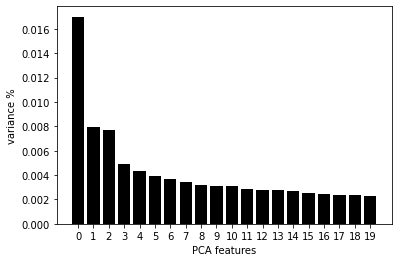

In [27]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(d)
# ks = range(1, 10)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters: model
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(scaled_features)
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()

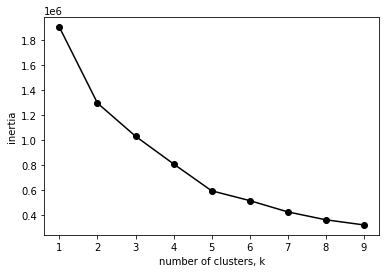

In [28]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:4])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [29]:
kmeans_pca = KMeans(
     init="random",
     n_clusters=7,
     n_init=10,
     max_iter=300,
     random_state=42
 )

In [30]:
kmeans_pca.fit(PCA_components.iloc[:,:10])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=7,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [31]:
df['cluster'] = kmeans_pca.labels_

In [32]:
df.cluster.value_counts()

0    15396
1     4592
2     1716
6      181
3       18
4       17
5        5
Name: cluster, dtype: int64

In [33]:
df = df.merge(games[['BGGId','Name']],on='BGGId',how='left')

In [34]:
df.head()

,BGGId,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,...,Theme_Ecology,Theme_Chernobyl,Theme_Photography,Theme_French Foreign Legion,Theme_Cruise ships,Theme_Apache Tribes,Theme_Rivers,Theme_Flags identification,cluster,Name
0,1,1986,4.3206,7.61428,7.10363,1.57979,3,5,14.366667,1.395833,...,0,0,0,0,0,0,0,0,2,Die Macher
1,2,1981,1.9630,6.64537,5.78447,1.45440,3,4,0.000000,27.000000,...,0,0,0,0,0,0,0,0,0,Dragonmaster
2,3,1998,2.4859,7.45601,7.23994,1.18227,2,4,9.307692,1.000000,...,0,0,0,0,0,0,0,0,2,Samurai
3,4,1992,2.6667,6.60006,5.67954,1.23129,2,4,13.000000,256.000000,...,0,0,0,0,0,0,0,0,0,Tal der Könige
4,5,1964,2.5031,7.33861,7.14189,1.33583,2,6,11.410256,21.152941,...,0,0,0,0,0,0,0,0,2,Acquire


In [35]:
df.to_csv("data/output/final_data_with_clusters.csv")

## Similarity Score

In [36]:
cols = [c for c in df.columns if c not in ['cluster','Name','BGGId']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[cols])

In [37]:
cluster_dict = df.set_index('Name').to_dict()['cluster']

In [38]:
len(cluster_dict)

21521

In [39]:
# similarities = cosine_similarity(scaled_features.transpose()) 

In [40]:
sims = cosine_similarity(df[cols])

In [41]:
np.shape(sims)

(21925, 21925)

In [42]:
# np.shape(similarities)

In [43]:
name_mapping = df[['Name']]

In [44]:
name_mapping

,Name
0,Die Macher
1,Dragonmaster
2,Samurai
3,Tal der Könige
4,Acquire
...,...
21920,Salvage
21921,Blitzkrieg!: World War Two in 20 Minutes
21922,Rock Paper Scissors: Deluxe Edition
21923,Splitter


In [45]:
cosine_sims = pd.DataFrame(sims)

In [46]:
cosine_sims = name_mapping.join(cosine_sims)

In [47]:
cosine_sims.rename(columns=name_mapping.to_dict()['Name'],inplace=True)

## Only keep similarities for games within same cluster

In [56]:
cosine_sims['cluster'] = df['Name'].map(cluster_dict)

In [57]:
cosine_sims = cosine_sims.loc[:,~cosine_sims.columns.duplicated()]

In [58]:
cosine_sims.head()

,Name,Die Macher,Dragonmaster,Samurai,Tal der Könige,Acquire,Mare Mediterraneum,Cathedral,Lords of Creation,El Caballero,...,System Gateway (fan expansion for Android: Netrunner),Voll verplant,Mille Fiori,7 Wonders: Architects,Azul: Queen's Garden,Salvage,Rock Paper Scissors: Deluxe Edition,Splitter,Captains' War,cluster
0,Die Macher,1.000000,-1.000000,-1.000000,-1.000000,0.930095,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.853611,0.919725,-1.000000,-1.0,-1.000000,-1.0,2
1,Dragonmaster,-1.000000,1.000000,0.909526,0.944848,-1.000000,0.940081,0.863342,0.942319,0.999336,...,0.942782,0.943487,0.942381,-1.000000,-1.000000,0.934773,-1.0,0.935360,-1.0,0
2,Samurai,-1.000000,0.909526,1.000000,0.846754,-1.000000,0.833558,0.822243,0.839399,0.922415,...,0.837494,0.839818,0.837631,-1.000000,-1.000000,0.825534,-1.0,0.826697,-1.0,0
3,Tal der Könige,-1.000000,0.944848,0.846754,1.000000,-1.000000,0.996249,0.928511,0.998166,0.941915,...,0.998637,0.999192,0.998280,-1.000000,-1.000000,0.991241,-1.0,0.991792,-1.0,0
4,Acquire,0.930095,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,0.750558,0.795474,-1.000000,-1.0,-1.000000,-1.0,2


In [59]:
all_games = [c for c in cosine_sims.columns if c != 'Name']

### THIS STEP WILL TAKE A LITTLE TO RUN

In [55]:
# t = time.localtime()
# current_time = time.strftime("%H:%M:%S", t)
# print(current_time)
# # adjust similarities for games in different clusters
# for game in all_games:
#     target_cluster = cluster_dict[game]
#     cosine_sims[game] = np.where(cosine_sims['cluster'] == target_cluster, cosine_sims[game], -1)
# t = time.localtime()
# current_time = time.strftime("%H:%M:%S", t)
# print(current_time)

14:23:27


KeyError: 'cluster'

In [53]:
final_cols = [c for c in cosine_sims.columns if c != 'cluster']

In [54]:
cosine_sims[final_cols].to_csv("data/output/all_similarities.csv")

KeyboardInterrupt: 